In [1]:
import pandas as pd
from scipy.signal import find_peaks_cwt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    df = pd.read_csv('dowjones.csv')
except:
    df = pd.read_csv("https://gist.githubusercontent.com/dtamayo/da79c85a22a24f3156b2d94e8c1a8a22/raw/266376e07118e1a811b4e8fad7b4b3a03a529555/dowjones.csv")
df['Date'] = pd.to_datetime(df['Date'])
def year_to_decimal(df):
    dayofyear = df['Date'].dt.dayofyear
    year = df['Date'].dt.year
    return year + dayofyear/365.

df['dec_year'] = year_to_decimal(df)
df.tail()

,Date,Open,High,Low,Close,Volume,dec_year
31774,2018-12-14,24408.04,24431.14,24033.79,24100.51,123952784.0,2018.953425
31775,2018-12-17,23986.83,24088.08,23456.88,23592.98,147762765.0,2018.961644
31776,2018-12-18,23769.13,23927.77,23516.02,23675.64,125914510.0,2018.964384
31777,2018-12-19,23693.33,24057.34,23162.64,23323.66,154537255.0,2018.967123
31778,2018-12-20,23224.12,23282.20,22644.31,22859.60,NaN,2018.969863


Text(0.5,1,'Dow Jones Industrial Average (Not adjusted for inflation)')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


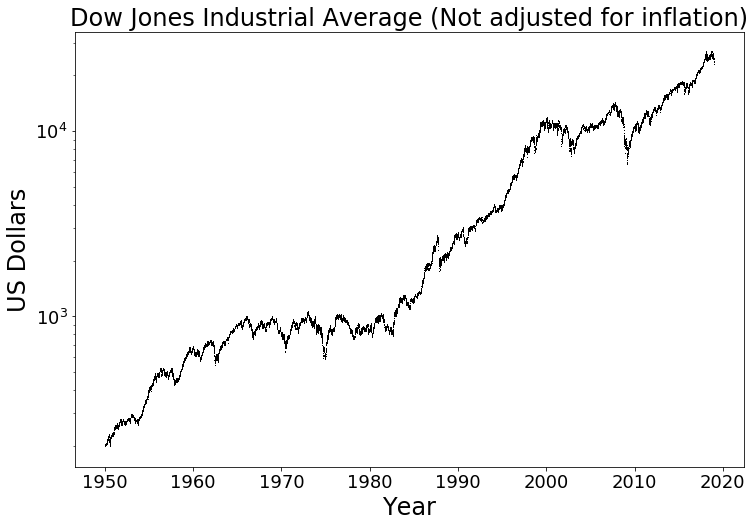

In [3]:
yearstart = 1950 # Only analyze from this year onwards

dfcut = df[df['dec_year'] > yearstart]
decyear = dfcut['dec_year'].dropna().values
close = dfcut['Close'].dropna().values

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(decyear, close, 'k,')
ax.set_yscale('log')
ax.set_xlabel('Year', fontsize=24)
ax.set_ylabel('US Dollars', fontsize=24)
ax.tick_params(labelsize=18)  
ax.set_title('Dow Jones Industrial Average (Not adjusted for inflation)', fontsize=24)

# Dow Jones Industrial Average since 1950

The DJIA is currently dropping, and we want to play the following game. Whenever it hits a minimum, if within 2 weeks it goes back up by 5%, we buy. We then hold the stock for 1.5 years and sell. 

We now analyze how well that strategy would do if we applied it at every such event in the DJIA since 1950. I leave the above parameters as adjustable variables below. You can change the values and go to the menu to the right of 'Insert' above ('Runtime' in Colab, 'Cell' in Jupyter) and select 'Run all'

In [4]:
num_increasing = 14 # Number of days from the minimum to check for an increase
incthresh = 0.05 # Threshold increase for whether we should buy (5% = 0.05)
holdlength=int(365*1.5) # How many days to hold the stock before selling

In [5]:
peakind = find_peaks_cwt(-close, np.arange(1,50), min_snr=5)


sigpeaks = []
for index in peakind:
    if index + num_increasing > len(decyear)-1:
        continue
    if (close[index+num_increasing]-close[index])/close[index] > incthresh:
        sigpeaks.append(index)
        
gains = []
start = []
for index in sigpeaks:
    if index+holdlength > len(decyear)-1:
        continue
    start.append(index)
    gains.append((close[index+holdlength]-close[index])/close[index])
gains = np.array(gains)*100 # change to percent

Npeaks = len(gains)
chancegain = (gains > 0).sum()/Npeaks
sortedgains = np.sort(gains)
quarter = sortedgains[int(Npeaks/4.)]
half = sortedgains[int(Npeaks/2.)]
threequarters = sortedgains[int(3*Npeaks/4.)]

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


# Events

Plot below will show points that satisfied the criteria to buy set above, color coded for the percent gain on investment over the length of time to hold set above.

Text(0.5,1,'41 Events Identified')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


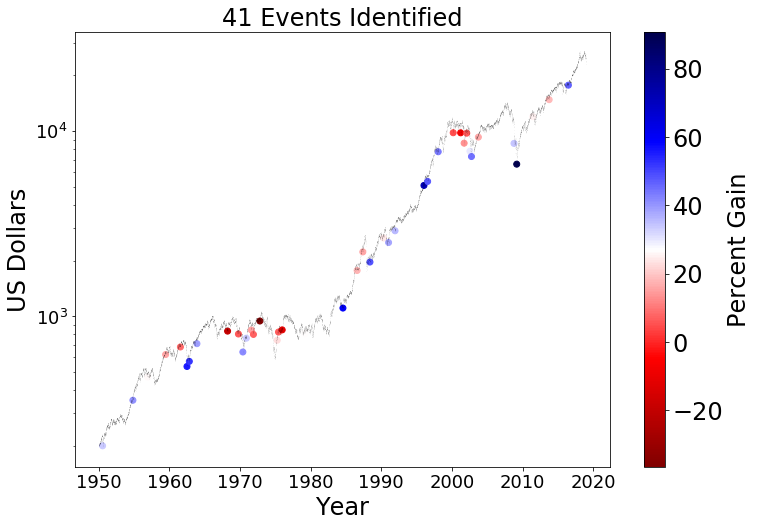

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
cm = plt.cm.get_cmap('seismic_r')
ax.plot(decyear, close, 'k,', alpha=0.03)
cb = ax.scatter(decyear[start], close[start], c=gains, cmap=cm)
ax.set_yscale('log')
cbar = plt.colorbar(cb)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Percent Gain', fontsize=24)
ax.set_xlabel('Year', fontsize=24)
ax.set_ylabel('US Dollars', fontsize=24)
ax.tick_params(labelsize=18)  
ax.set_title('{0} Events Identified'.format(Npeaks), fontsize=24)

# Outcomes

Histogram below gives the distribution of outcomes over all events identified above. The red lines denote the 25%, 50% and 75% intervals from left to right

Text(0.5,1,'Positive gain 90.2% of the time')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


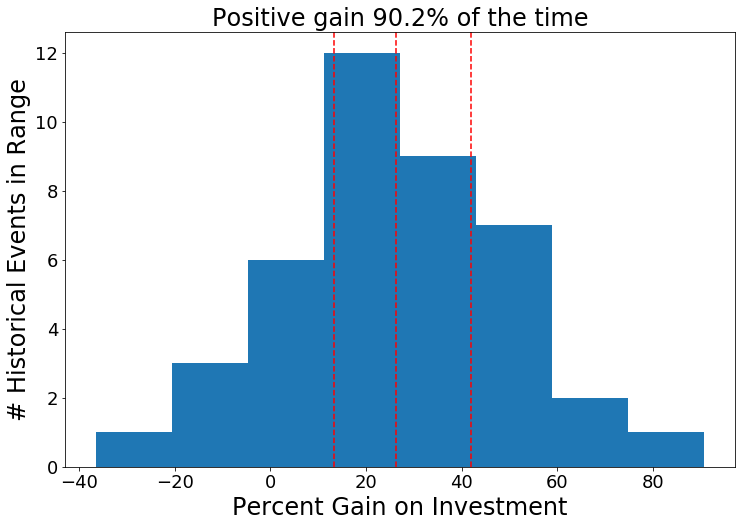

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
N, bins, patches = ax.hist(gains, bins=8)
ax.axvline(quarter, c='r', linestyle='--')
ax.axvline(half, c='r', linestyle='--')
ax.axvline(threequarters, c='r', linestyle='--')
ax.set_xlabel('Percent Gain on Investment', fontsize=24)
ax.set_ylabel('# Historical Events in Range', fontsize=24)
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(18) 
ax.set_title('Positive gain {0:.1f}% of the time'.format(chancegain*100), fontsize=24)